In [105]:
import numpy as np
import pandas as pd

In [106]:
def prepare_2006():
 excel_file = pd.ExcelFile('IPC _2006_f.xlsx')
 sheet_names = excel_file.sheet_names

 data=pd.read_excel('IPC _2006_f.xlsx',sheet_name=None)
 df=pd.DataFrame()
 df.head()
 for i in sheet_names:
      df_1=data[i]
      year=i[4:]
      new_col=[]
      df_1.columns = df_1.columns.str.strip().str.replace(' ', '')
      for col in df_1.columns:

            if col not in ['VILLE','LIBELLE','code']:
                  new_col.append(f"{col}-{year}")
            else:
                  new_col.append(col)
      df_1.columns=new_col
 df=pd.DataFrame()
 for i in sheet_names:
    df_temp=data[i]
    df=pd.concat([df,df_temp],axis=1)
 df.head()
 month_map = {
    'janvier': '01',
    'février': '02',
    'mars': '03',
    'avril': '04',
    'mai': '05',
    'juin': '06',
    'juillet': '07',
    'août': '08',
    'septembre': '09',
    'octobre': '10',
    'novembre': '11',
    'décembre': '12'
}
 cols=[]
 for m in df.columns:
    if m not in ['VILLE','LIBELLE','code']:
          cols.append(pd.to_datetime(f"01-{month_map[m.split('-')[0]]}-{m.split('-')[1]}",dayfirst=True))
    else:
         cols.append(m)
 df.columns=cols
 df.drop(['VILLE','code'],axis=1,inplace=True)
 df = df.loc[:, ~df.columns.duplicated()]
 df=df[df['LIBELLE']=='GENERAL']
 df=df.drop('LIBELLE',axis=1)
 df=df.transpose()
 df=df.reset_index()
 df.columns=['Date','IPC']
 return df


In [107]:
def preparing_df(df):
  def verify_date(col):
    try:
        pd.to_datetime(col,format="%Y-%m-%d %H:%M:%S")
        return True
    except:
        return False
  city_map={
    1:'Agadir',
    2:'Casablanca',
    3:'Fes',
    4:'Kenitra',
    5:'Marrackech',
    6:'Oujda',
    7:'Rabat',
    8:'Tetouan',
    9:'Meknes',
    10:'Tanger',
    11:'Laayoune',
    12:'Dakhla',
    13:'Guelmim',
    14:'Settat',
    15:'Safi',
    16:'Beni Mellal',
    17:'Al-Houcima',
    18:'Errachidia',
    99:"National"
}
  date_cols=[col for col in df.columns  if verify_date(col)]
  df=df.melt(id_vars=["VILLE","coicop","libelle"],var_name="Date",value_vars=date_cols,value_name="IPC")
  df["VILLE"]=df["VILLE"].map(city_map)
  df["Date"]=pd.to_datetime(df["Date"],errors="coerce").astype(str)
  df=df[(df['VILLE']=="National")&(df['libelle']=='GENERAL')]
  df=df.drop(['VILLE','coicop','libelle'],axis=1)
  return df


In [108]:
df_2006=prepare_2006()
df_2017=pd.read_excel('IPC.xlsx')
df_2017=preparing_df(df_2017)

In [109]:
#effectuons le chainage:
IPC_2017=df_2017[df_2017['Date']=='2017-12-01']['IPC'].values[0]
IPC_2006=df_2006[df_2006['Date']=='2017-12-01']['IPC'].values[0]
print("IPC 2017:",IPC_2017)
print("IPC 2006",IPC_2006)

IPC 2017: 101.2
IPC 2006 119.7


In [110]:
variation=(IPC_2017)/IPC_2006
print("variation:",variation)

variation: 0.8454469507101086


In [111]:
df_2006["IPC"]=round(df_2006["IPC"]*variation,1)

In [112]:
df_2006=df =df_2006[df_2006['Date'] < '2017-01-01']
df_2006.head()

,Date,IPC
0,2007-01-01,85.8
1,2007-02-01,85.6
2,2007-03-01,85.9
3,2007-04-01,86.7
4,2007-05-01,85.7


In [113]:
df_finaly=pd.concat([df_2006,df_2017],ignore_index=True)

In [114]:
df_finaly['Date']=pd.to_datetime(df_finaly['Date'])

In [115]:
df_finaly.head()

,Date,IPC
0,2007-01-01,85.8
1,2007-02-01,85.6
2,2007-03-01,85.9
3,2007-04-01,86.7
4,2007-05-01,85.7


In [116]:
df_finaly=df_finaly.set_index('Date')
df_finaly.head()

,IPC
Date,
2007-01-01,85.8
2007-02-01,85.6
2007-03-01,85.9
2007-04-01,86.7
2007-05-01,85.7


In [ ]:

train_size=int(len(df_finaly)*0.8)
train=df_finaly[:'2024-05-01']
test=df_finaly['2024-05-01':]
print("train size:",len(train))
print("test size:",len(test))
print("nombre d'observation:",len(df_finaly))
print("glimpse of test",test[:5])

train size: 209
test size: 13
nombre d'observation: 221
glimpse of test               IPC
Date             
2024-05-01  118.5
2024-06-01  119.0
2024-07-01  118.8
2024-08-01  119.7
2024-09-01  119.7


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(train)
train_scaled=scaler.transform(train)
test_scaled=scaler.transform(test)

In [ ]:
#time series generator:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length=seq_size=6
batch_size=1
train_scaled=train_scaled.reshape(-1,1)

In [ ]:
train_generator=TimeseriesGenerator(train_scaled,train_scaled,length=length,batch_size=batch_size)
print("train genrator shape:",len(train_generator))
x,y=train_generator[0]
print(f"x:\n{x}")
print(f"y:\n{y}")

train genrator shape: 203
x:
[[[-1.59180281]
  [-1.61635987]
  [-1.57952428]
  [-1.48129603]
  [-1.60408134]
  [-1.56724575]]]
y:
[[-1.56724575]]


In [ ]:
test_scaled=test_scaled.reshape(-1,1)

In [ ]:
test_generator=TimeseriesGenerator(test_scaled,test_scaled,length=length,batch_size=batch_size)
print("test generator length",len(test_generator))
x,y=test_generator[0]
print(f"x:\n{x}")
print(f"y:\n{y}")

test generator length 7
x:
[[[2.4232767 ]
  [2.48466936]
  [2.4601123 ]
  [2.57061907]
  [2.57061907]
  [2.53378348]]]
y:
[[2.50922642]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM


In [ ]:
model=Sequential()
model.add(LSTM(50,activation='tanh',return_sequences=True ,input_shape=(length,1)))
model.add(LSTM(50,activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(train_generator,epochs=50,verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1581
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0153
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0328
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0168
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0177
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0307
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0139
Epoch 8/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0141
Epoch 9/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0137
Epoch 10/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125
Epoch 11/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125
Epoch 12/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114
Epoch 13/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0125
Epoch 14/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0109
Epoch 15/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0079


In [ ]:
model.save("lstm_model.keras")

In [ ]:
len(test_pred)

7

In [ ]:

from sklearn.metrics import mean_squared_error as mse
test_pred=model.predict(test_generator)
y_pred=scaler.inverse_transform(test_pred)
print(y_pred)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[[118.5963  ]
 [118.56958 ]
 [118.520836]
 [118.92769 ]
 [118.915146]
 [118.74841 ]
 [118.67615 ]]


In [ ]:
y_true=[]
for i in range(len(test_generator)):
  x,y=test_generator[i]
  y_true.append(y)
y_true = np.array(y_true).reshape(-1, 1)
y_true=scaler.inverse_transform(y_true)
print(y_true)

[[119.2]
 [119. ]
 [119.9]
 [120.3]
 [119.9]
 [119.5]
 [119. ]]


In [ ]:
MSE=mse(y_true,y_pred)
print(f"MSE={MSE:.3f}")
RMSE=np.sqrt(MSE)
print(f"RMSE={RMSE:.3f}")

MSE=0.854
RMSE=0.924


In [ ]:
MAPE=np.mean(np.abs(y_true-y_pred)/np.abs(y_true))*100
print(f"MAPE={MAPE:.3f}")

MAPE=0.697


In [ ]:
all_dates=df_finaly.loc["2024-10-01	":"2025-05-01"].index

In [ ]:
last_val=df_finaly.loc["2024-10-01"].values[0]

In [ ]:
y_pred=np.concatenate([[last_val], y_pred.flatten()])

In [ ]:
print(y_pred)

[119.4        118.59629822 118.56958008 118.52083588 118.9276886
 118.91514587 118.74841309 118.67614746]


In [ ]:
dates=df_finaly.iloc[-len(y_pred):].index

In [ ]:
len(dates)

7

In [ ]:
len(y_pred)

7

In [ ]:
df_metrics = pd.DataFrame({
    "dates": dates,
    "y_true": y_true.flatten(),
    "y_pred": y_pred .flatten()

})

In [ ]:
df_metrics.head()

,dates,y_true,y_pred
0,2024-11-01,119.2,118.596298
1,2024-12-01,119.0,118.569580
2,2025-01-01,119.9,118.520836
3,2025-02-01,120.3,118.927689
4,2025-03-01,119.9,118.915146


In [ ]:
df_metrics.to_csv("df_metrics.csv")

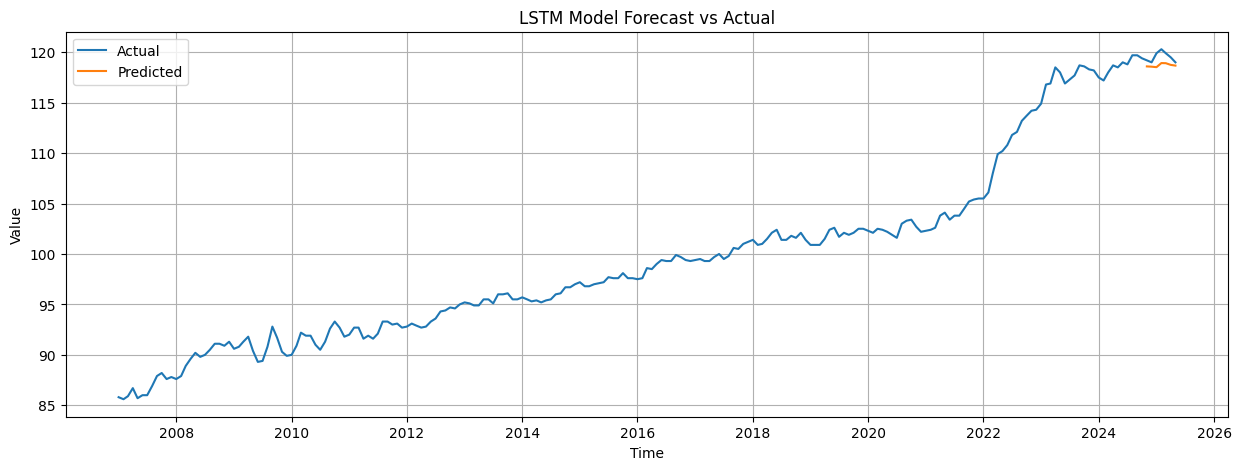

In [ ]:
#visualize it:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(df_finaly.index,df_finaly, label="Actual")
plt.plot(dates,y_pred, label="Predicted")
plt.title("LSTM Model Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#forecasting next 12 months:
#take the last seq_len batch
df_finaly_last=df_finaly[-24:]
df_finaly_last=scaler.transform(df_finaly_last)
df_finaly_last=df_finaly_last.reshape(-1,1)
df_finaly_last

array([[2.22682021],
       [2.27593434],
       [2.32504846],
       [2.44783376],
       [2.43555523],
       [2.39871964],
       [2.38644111],
       [2.3004914 ],
       [2.26365581],
       [2.36188405],
       [2.44783376],
       [2.4232767 ],
       [2.48466936],
       [2.4601123 ],
       [2.57061907],
       [2.57061907],
       [2.53378348],
       [2.50922642],
       [2.48466936],
       [2.59517613],
       [2.64429025],
       [2.59517613],
       [2.54606201],
       [2.48466936]])

In [ ]:
#forecast reccurently

In [ ]:
current_input=df_finaly_last
time_step=12
forecasts=[]
for i in range(time_step):
  forecast=model.predict(current_input,verbose=0)
  forecasts.append(forecast[0][0])
  current_input=np.append(current_input[1:],forecast,axis=0)
forecasts=np.array(forecasts).reshape(-1,1)
forecasts=scaler.inverse_transform(forecasts)
print(forecasts)

[[114.21524 ]
 [114.4153  ]
 [114.610374]
 [115.07699 ]
 [115.03165 ]
 [114.89389 ]
 [114.84738 ]
 [114.51345 ]
 [114.36575 ]
 [114.75348 ]
 [115.07699 ]
 [114.986015]]


In [ ]:
last_real_value =df_finaly.iloc[-1].values[0]


In [ ]:
all_forecast = np.concatenate([[last_real_value], forecasts.flatten()])

In [ ]:
dates=pd.date_range(start='2025-05-01', end='2026-05-01', freq='MS')
print(dates)

DatetimeIndex(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01'],
              dtype='datetime64[ns]', freq='MS')


In [ ]:
forecast=pd.DataFrame({'Date':dates,'Forecast':all_forecast})
forecast.head()

,Date,Forecast
0,2025-05-01,119.000000
1,2025-06-01,114.215240
2,2025-07-01,114.415298
3,2025-08-01,114.610374
4,2025-09-01,115.076988


In [ ]:
forecast.to_csv("df_forecast_12.csv")

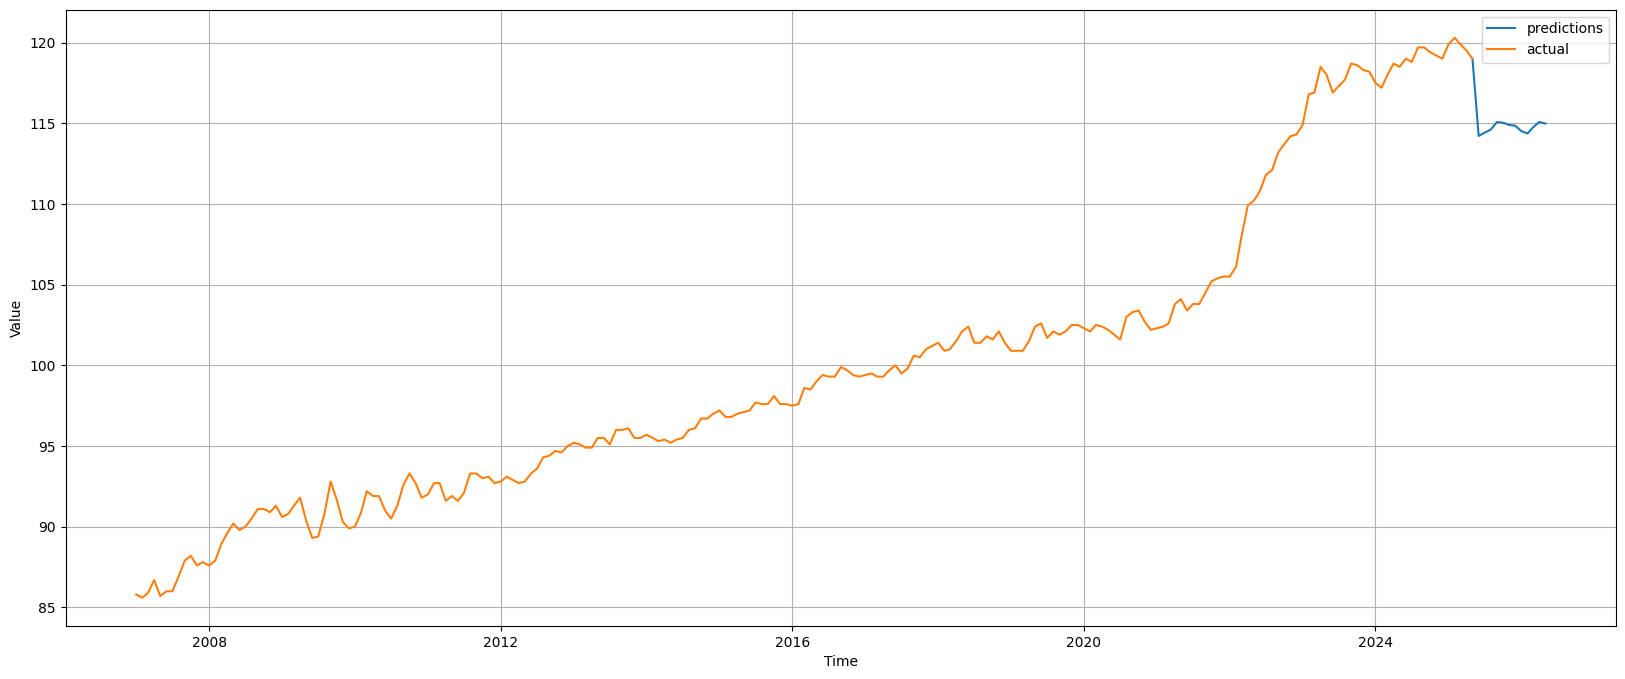

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(dates,all_forecast,label="predictions")
plt.plot(df_finaly,label="actual")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# LSTM multivariate

In [ ]:
def prepare_europe():
  IPC_europe=pd.read_excel("IPC_europe.xlsx")
  def verify_date(col):
    try:
        pd.to_datetime(col)
        return True
    except:
        return False
  cols=[]
  for col in IPC_europe.columns :
      if verify_date(col):
          cols.append(pd.to_datetime(col).strftime('%Y-%m-%d'))
      else:
        cols.append(col)
  IPC_europe.columns=cols
  IPC_europe.drop(IPC_europe.index[0],inplace=True)
  value_cols = [col for col in IPC_europe.columns if col != "Time period"]
  IPC_eur=pd.melt(IPC_europe,id_vars=["Time period"],value_vars=value_cols,var_name="Date",value_name="IPC")
  IPC_eur=IPC_eur[IPC_eur['Date']>='2007-01-01']
  IPC_pivot=pd.pivot_table(IPC_eur,index="Date",columns="Time period",values="IPC")
  IPC_pivot=IPC_pivot.sort_index()
  IPC_pivot.index=pd.to_datetime(IPC_pivot.index)
  return IPC_pivot

In [ ]:
IPC_europe=prepare_europe()
IPC_europe.head()

FileNotFoundError: [Errno 2] No such file or directory: 'IPC_europe.xlsx'

In [ ]:
IPC_full=pd.concat([df_finaly,IPC_europe],axis=1)
IPC_full.head()

,IPC,Belgium,France,Italy,Spain
Date,,,,,
2007-01-01,85.8,85.18124,89.40,86.90155,86.85111
2007-02-01,85.6,85.63712,89.57,87.16772,86.91000
2007-03-01,85.9,85.64703,89.95,87.30080,87.56944
2007-04-01,86.7,86.03355,90.39,87.43388,88.77914
2007-05-01,85.7,85.93444,90.61,87.70004,89.02322


In [ ]:
IPC_corr=IPC_full.corr()
IPC_corr

,IPC,Belgium,France,Italy,Spain
IPC,1.000000,0.993037,0.992161,0.987019,0.984634
Belgium,0.993037,1.000000,0.995895,0.990737,0.991426
France,0.992161,0.995895,1.000000,0.993610,0.994566
Italy,0.987019,0.990737,0.993610,1.000000,0.992884
Spain,0.984634,0.991426,0.994566,0.992884,1.000000


In [ ]:
scaler=StandardScaler()

In [ ]:
IPC_full_scaled=scaler.fit_transform(IPC_full)
IPC_full_scaled.shape

(221, 5)

In [ ]:
train_size=len(IPC_full.loc[:'2024-04-01'])
train_size


208

In [ ]:
#splitting data:

train=IPC_full_scaled[:train_size]
test=IPC_full_scaled[train_size:]
print("train size:",len(train))
print("test size:",len(test))
print("nombre d'observation:",len(IPC_full_scaled))
print("glimpse of test",test[:5])

train size: 208
test size: 13
nombre d'observation: 221
glimpse of test [[2.02225997 2.00195385 2.16294778 2.0348154  2.15861107]
 [2.07658479 2.02422913 2.1739448  2.0456505  2.20672229]
 [2.05485486 2.09643392 2.20082643 2.09982601 2.14581027]
 [2.15263954 2.09643392 2.27902751 2.12149621 2.15099449]
 [2.15263954 2.04573711 2.09574372 2.09982601 2.07398357]]


In [ ]:
#creating sequences:
def create_sequence(data,seq_length):
  X=[]
  y=[]
  for i in range(len(data)-seq_length):
    X.append(data[i:i+seq_length,:])
    y.append(data[i+seq_length,:])
  X=np.array(X)
  y=np.array(y)
  return X,y


In [ ]:
X,y=create_sequence(train,seq_length=6)
print("X:",X[0,:])
print("y:",y[:5,:])

X: [[-1.53058345 -1.50302142 -1.58948237 -1.61644573 -1.66417839]
 [-1.55231338 -1.46768789 -1.56871021 -1.58760594 -1.65810883]
 [-1.51971849 -1.4669198  -1.52227832 -1.57318658 -1.59014298]
 [-1.43279877 -1.4369621  -1.46851507 -1.55876723 -1.46546403]
 [-1.54144841 -1.44464374 -1.44163345 -1.52992853 -1.44030767]
 [-1.50885352 -1.44541183 -1.42819264 -1.5082995  -1.42342649]]
y: [[-1.50885352 -1.41699107 -1.45629615 -1.48667047 -1.49039982]
 [-1.41106884 -1.42544003 -1.41108615 -1.47225112 -1.47782164]
 [-1.30241919 -1.41929533 -1.39886723 -1.47225112 -1.44781088]
 [-1.2698243  -1.38396102 -1.37076372 -1.44341241 -1.32897886]
 [-1.33501409 -1.32097482 -1.30966912 -1.40736403 -1.26244666]]


In [ ]:
X.shape

(202, 6, 5)

In [ ]:
model_mult=Sequential()
model_mult.add(LSTM(50,activation="tanh",return_sequences=True,input_shape=(X.shape[1],X.shape[2])))
model_mult.add(LSTM(50,activation="tanh"))
model_mult.add(Dense(5))
model_mult.compile(optimizer="adam",loss="mse")
model_mult.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 6, 50)          │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,655 (123.65 KB)

 Trainable params: 31,655 (123.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model_mult.fit(X,y,epochs=50,verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7024
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4649 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2232 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0510 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0430 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0378 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0226 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0191 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━

In [ ]:
X_test,y_test=create_sequence(test,seq_length=6)

In [ ]:
y_pred=model_mult.predict(X_test)
y_pred=scaler.inverse_transform(y_pred)
y_true=scaler.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


In [ ]:
IPC_full.iloc[train_size:]

,IPC,Belgium,France,Italy,Spain
Date,,,,,
2024-05-01,118.5,130.4031,120.11,120.6,123.9418
2024-06-01,119.0,130.6905,120.20,120.7,124.4086
2024-07-01,118.8,131.6221,120.42,121.2,123.8176
2024-08-01,119.7,131.6221,121.06,121.4,123.8679
2024-09-01,119.7,130.9680,119.56,121.2,123.1207
2024-10-01,119.4,131.6023,119.89,121.2,123.8883
2024-11-01,119.2,131.8203,119.72,121.1,124.1923
2024-12-01,119.0,132.3456,119.95,121.2,124.7533
2025-01-01,119.9,134.1790,120.14,121.9,124.9663


In [ ]:
dates=IPC_full.iloc[train_size+6:].index
dates

DatetimeIndex(['2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01', '2025-05-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
len(dates)

7

In [ ]:
y_pred.shape

(7, 5)

In [ ]:
y_pred[0,:]

array([119.05469 , 128.8618  , 118.722435, 121.55103 , 121.67867 ],
      dtype=float32)

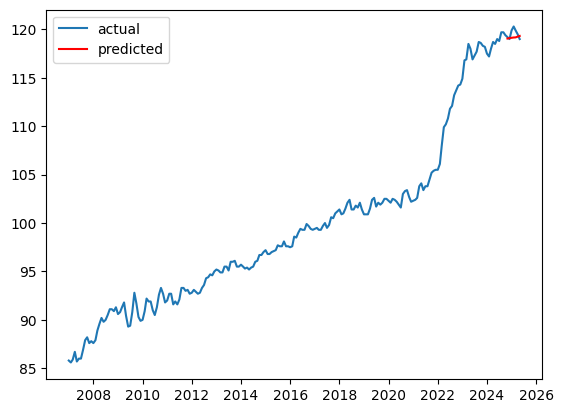

In [ ]:
plt.plot(IPC_full['IPC'],label="actual")
plt.plot(dates,y_pred[:,0],label="predicted",color="red")
plt.legend()
plt.show()

In [ ]:
MSE=mse(y_true,y_pred)
print(f"MSE={MSE:.3f}")
RMSE=np.sqrt(MSE)
print(f"RMSE={RMSE:.3f}")

MSE=7.484
RMSE=2.736


# Prophet model

In [ ]:
#prophet:
df_prophet=df_finaly.reset_index()

In [ ]:
df_prophet=df_prophet.rename(columns={'Date':'ds','IPC':'y'})
df_prophet.head()

,ds,y
0,2007-01-01,85.8
1,2007-02-01,85.6
2,2007-03-01,85.9
3,2007-04-01,86.7
4,2007-05-01,85.7


In [ ]:
from prophet import Prophet

In [ ]:
m=Prophet(yearly_seasonality=True)

In [ ]:
m.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ig_ke3b/0pgxgq18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ig_ke3b/6bbin483.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94419', 'data', 'file=/tmp/tmp2ig_ke3b/0pgxgq18.json', 'init=/tmp/tmp2ig_ke3b/6bbin483.json', 'output', 'file=/tmp/tmp2ig_ke3b/prophet_model4coyeikv/prophet_model-20250726084247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
581,2026-04-27
582,2026-04-28
583,2026-04-29
584,2026-04-30
585,2026-05-01


In [ ]:
forecast=m.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
581,2026-04-27,128.437910,127.040602,129.899238
582,2026-04-28,128.299560,126.804448,129.799997
583,2026-04-29,128.115640,126.543536,129.565913
584,2026-04-30,127.889902,126.412233,129.432412
585,2026-05-01,127.627260,126.086898,129.103072


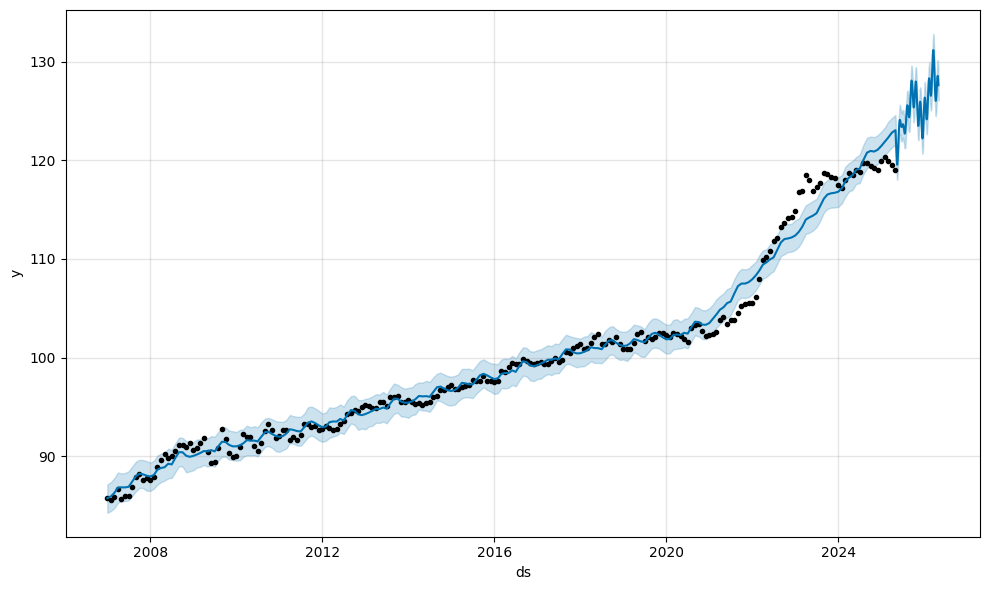

In [ ]:
fig1 = m.plot(forecast)



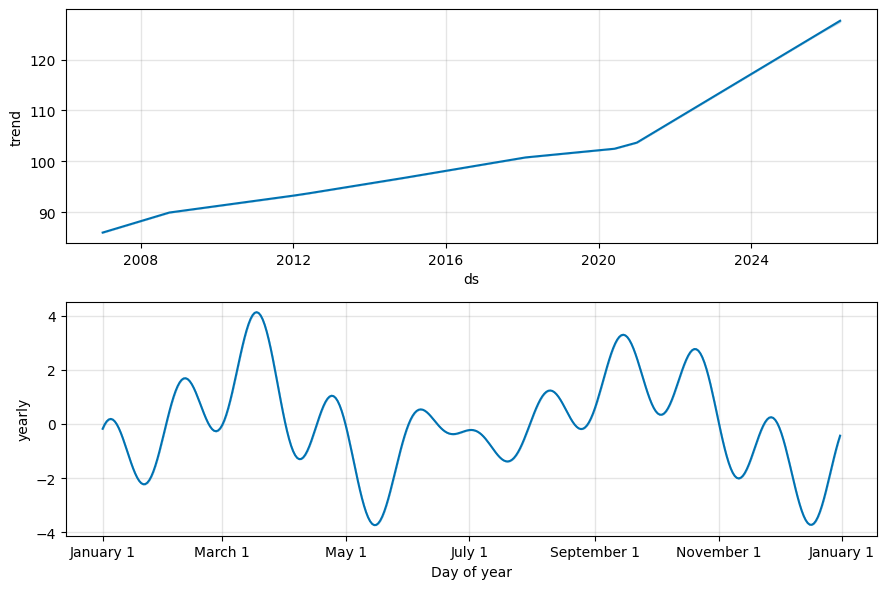

In [ ]:
fig2 = m.plot_components(forecast)



In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

In [ ]:
#visualize change points change in trend

[[<matplotlib.lines.Line2D at 0x7bfd8ead95d0>],

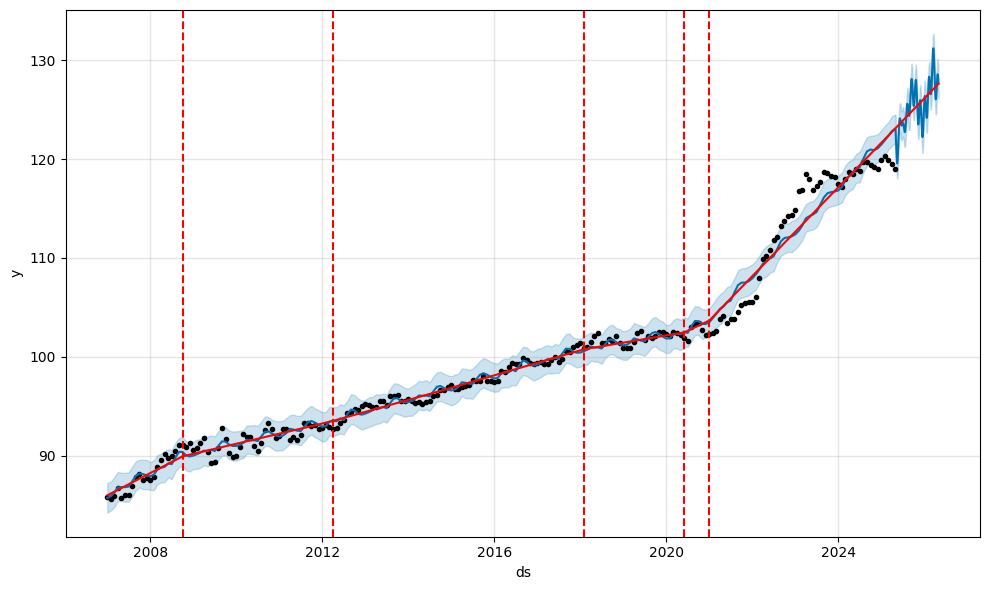

In [ ]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(m.predict(forecast))
add_changepoints_to_plot(fig.gca(), m, m.predict(forecast))

In [ ]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-01-01,86.006320,84.254048,87.127749,86.006320,86.006320,-0.271501,-0.271501,-0.271501,-0.271501,-0.271501,-0.271501,0.0,0.0,0.0,85.734819
1,2007-02-01,86.197457,84.438695,87.373786,86.197457,86.197457,-0.269620,-0.269620,-0.269620,-0.269620,-0.269620,-0.269620,0.0,0.0,0.0,85.927837
2,2007-03-01,86.370097,84.717914,87.758168,86.370097,86.370097,-0.110538,-0.110538,-0.110538,-0.110538,-0.110538,-0.110538,0.0,0.0,0.0,86.259559
3,2007-04-01,86.561234,85.269939,88.342631,86.561234,86.561234,0.247343,0.247343,0.247343,0.247343,0.247343,0.247343,0.0,0.0,0.0,86.808577
4,2007-05-01,86.746206,85.397129,88.239258,86.746206,86.746206,0.090236,0.090236,0.090236,0.090236,0.090236,0.090236,0.0,0.0,0.0,86.836443


In [ ]:
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 32 forecasts with cutoffs between 2009-01-20 00:00:00 and 2024-05-01 00:00:00


  0%|          | 0/32 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ig_ke3b/6gncobn8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ig_ke3b/cclvx_j7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51086', 'data', 'file=/tmp/tmp2ig_ke3b/6gncobn8.json', 'init=/tmp/tmp2ig_ke3b/cclvx_j7.json', 'output', 'file=/tmp/tmp2ig_ke3b/prophet_modelpgqd55ys/prophet_model-20250726084320.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:43:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ig_ke3b/m8swu49g.json
DEBUG:cmdstanpy:input tempfi

In [ ]:

df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,38 days,1.988516,1.410147,0.944239,0.009110,0.006404,0.009168,0.447368
1,39 days,1.966828,1.402436,0.924994,0.008913,0.006148,0.008971,0.473684
2,40 days,1.994636,1.412316,0.951364,0.009193,0.006642,0.009247,0.447368
3,43 days,1.991190,1.411095,0.948707,0.009177,0.006324,0.009230,0.447368
4,44 days,2.088955,1.445322,0.998848,0.009709,0.006818,0.009768,0.421053


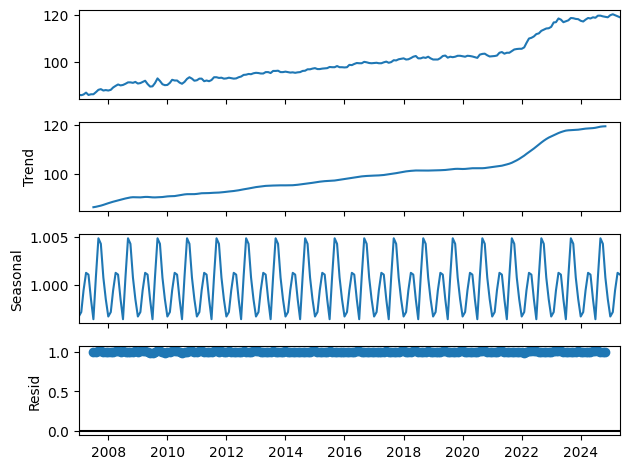

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
TSA=seasonal_decompose(df_finaly,model="multiplicative").plot()

In [ ]:
train_holt_winter=df_finaly[:'2024-05-01']
test_holt_winter=df_finaly['2024-05-01':]

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_holt_winter=ExponentialSmoothing(train_holt_winter,seasonal_periods=12,trend="mul",seasonal="add").fit(optimized=True)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
forecast_holt_winter=model_holt_winter.forecast(len(test_holt_winter))


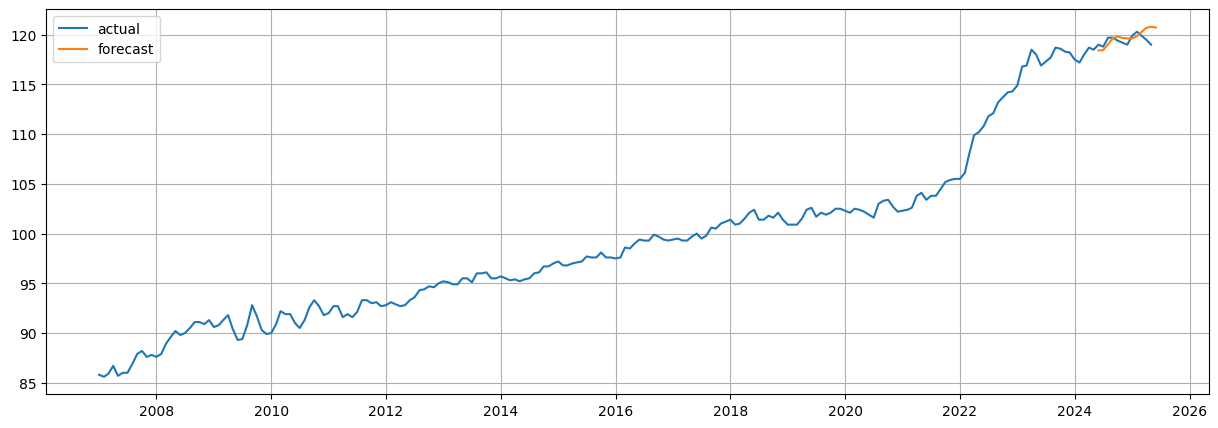

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(df_finaly,label="actual")
plt.plot(forecast_holt_winter,label="forecast")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
future_holt_winter=model_holt_winter.forecast(len(test_holt_winter)+12)

In [ ]:
future_holt_winter

,0
2024-06-01,118.427669
2024-07-01,118.453421
2024-08-01,119.053317
2024-09-01,119.664139
2024-10-01,119.817069
2024-11-01,119.670288
2024-12-01,119.623037
2025-01-01,119.634091
2025-02-01,119.854210
2025-03-01,120.267905


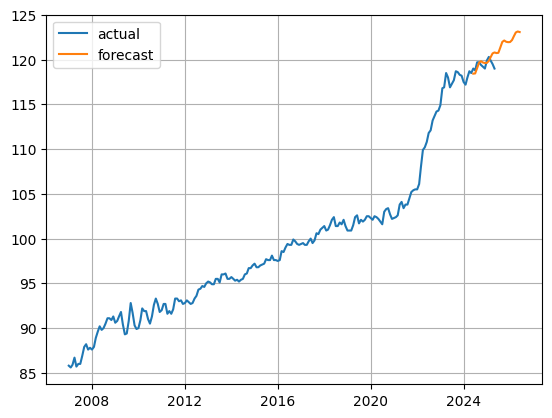

In [ ]:
plt.plot(df_finaly,label="actual")
plt.plot(future_holt_winter,label="forecast")
plt.legend()
plt.grid(True)
plt.show()